In [346]:
import warnings

In [347]:
warnings.filterwarnings('ignore')

In [348]:
# Install necessary libraries

In [349]:
!pip install biopython

In [350]:
!pip install torch_geometric torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.5.1+cu124.html


Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu124.html


In [351]:
# Import required libraries

In [352]:
import os

In [353]:
import pandas as pd

In [354]:
import numpy as np

In [355]:
import matplotlib.pyplot as plt

In [356]:
import seaborn as sns

In [357]:
from mpl_toolkits.mplot3d import Axes3D

In [358]:
from Bio.PDB import PDBParser

In [359]:
from Bio.PDB.MMCIFParser import MMCIFParser

In [360]:
from Bio.PDB.MMCIF2Dict import MMCIF2Dict

In [361]:
import torch

In [362]:
import torch.nn as nn

In [363]:
import torch.nn.functional as F

In [364]:
import torch.optim as optim

In [365]:
from torch import autocast

In [366]:
from torch.cuda.amp import GradScaler

In [367]:
from torch.utils.data import Dataset, DataLoader, TensorDataset

In [368]:
from torch_geometric.nn import GCNConv, global_mean_pool

In [369]:
from sklearn.model_selection import train_test_split

In [370]:
import shap

In [371]:
# Define the dataset path

In [372]:
dataset_path = "/content/6TF2.cif.txt"

In [373]:
# Initialize the parser

In [374]:
parser = MMCIFParser(QUIET=True)

In [375]:
# Parse the mmCIF file into a dictionary

In [376]:
structure = parser.get_structure("6TF2", dataset_path)

In [377]:
# Extract atomic coordinates, residues, and chains

In [378]:
data = []
for model in structure:
    for chain in model:
        for residue in chain:
            for atom in residue:
                data.append([
                    model.id,        # Model ID
                    chain.id,        # Chain ID
                    residue.id[1],   # Residue Number
                    residue.resname, # Residue Name
                    atom.name,       # Atom Name
                    atom.coord[0],   # X-coordinate
                    atom.coord[1],   # Y-coordinate
                    atom.coord[2],   # Z-coordinate
                    atom.occupancy,  # Occupancy
                    atom.bfactor     # B-Factor (Temperature Factor)
                ])


In [379]:
# Convert the dictionary to a DataFrame

In [380]:
columns = ["Model", "Chain", "Residue_Number", "Residue_Name", "Atom_Name", "X", "Y", "Z", "Occupancy", "B-Factor"]


In [381]:
df = pd.DataFrame(data, columns=columns)

In [382]:
# Display the first few rows

In [383]:
print("First few rows of atomic data:")
print(df.head())

First few rows of atomic data:
   Model Chain  Residue_Number Residue_Name Atom_Name      X      Y      Z  \
0      0     A               1            G       O5'  7.901  5.652  2.845   
1      0     A               1            G       C5'  6.860  6.478  2.349   
2      0     A               1            G       C4'  5.528  5.767  2.371   
3      0     A               1            G       O4'  5.443  4.853  1.246   
4      0     A               1            G       C3'  5.260  4.886  3.578   

   Occupancy   B-Factor  
0        1.0  119.88279  
1        1.0  123.92538  
2        1.0  127.79427  
3        1.0  129.84188  
4        1.0  126.24935  


In [384]:
# Convert DataFrame to NumPy array

In [385]:
atom_data = df[["X", "Y", "Z"]].to_numpy()

In [386]:
print("\nNumPy Array Shape:", atom_data.shape)


NumPy Array Shape: (1166, 3)


In [387]:
# Create a 3D scatter plot of atomic coordinates

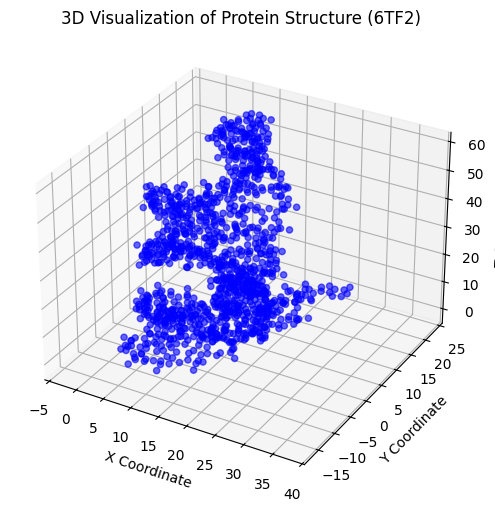

In [388]:
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(df["X"], df["Y"], df["Z"], c="blue", marker="o", alpha=0.6)

ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
ax.set_zlabel("Z Coordinate")
ax.set_title("3D Visualization of Protein Structure (6TF2)")

plt.show()

In [389]:
# Parse the mmCIF file into a dictionary

In [390]:
cif_dict = MMCIF2Dict(dataset_path)

In [391]:
# Convert the dictionary to a DataFrame

In [392]:
df_cif = pd.DataFrame(dict([(key, pd.Series(value)) for key, value in cif_dict.items()]))


In [393]:
# Define the output CSV file path

In [394]:
csv_output_path = "/content/6TF2_full_structure.csv"

In [395]:
# Save the DataFrame as a CSV file

In [396]:
df_cif.to_csv(csv_output_path, index=False)

In [397]:
# Print essential insights

In [398]:
print(f"\n🔹 Shape: {df.shape}")  # (rows, columns)
print(f"\n🔹 Columns: {df.columns.tolist()}")


🔹 Shape: (1166, 10)

🔹 Columns: ['Model', 'Chain', 'Residue_Number', 'Residue_Name', 'Atom_Name', 'X', 'Y', 'Z', 'Occupancy', 'B-Factor']


In [399]:
# Check for missing values (only showing if present)

In [400]:
missing = df.isnull().sum()
if missing.any():
    print("\n⚠️ Missing Values (Top 5 Columns):")
    print(missing[missing > 0].head())

In [401]:
# Check for duplicates

In [402]:
duplicates = df.duplicated().sum()
print(f"\n🔹 Duplicate Rows: {duplicates}")


🔹 Duplicate Rows: 0


In [403]:
# Show data types (only first 5 columns)

In [404]:
print("\n🔹 Data Types (First 5 Columns):")
print(df.dtypes.head())


🔹 Data Types (First 5 Columns):
Model              int64
Chain             object
Residue_Number     int64
Residue_Name      object
Atom_Name         object
dtype: object


In [405]:
# Display unique values for first 5 categorical columns

In [406]:
categorical_cols = df.select_dtypes(include=['object']).columns[:5]
if not categorical_cols.empty:
    print("\n🔹 Unique Values (First 5 Categorical Columns):")
    for col in categorical_cols:
        print(f"  - {col}: {df[col].nunique()} unique values")



🔹 Unique Values (First 5 Categorical Columns):
  - Chain: 1 unique values
  - Residue_Name: 9 unique values
  - Atom_Name: 55 unique values


In [407]:
# Display summary for first 5 numerical columns

In [408]:
print("\n🔹 Summary Stats (First 5 Numerical Columns):")
print(df.describe().iloc[:, :5].loc[['min', 'max', 'mean', 'std']])


🔹 Summary Stats (First 5 Numerical Columns):
      Model  Residue_Number          X          Y          Z
min     0.0        1.000000  -2.891000 -16.377001  -0.995000
max     0.0      204.000000  37.438999  23.021999  58.915001
mean    0.0       30.804460  13.265620   1.412287  27.992294
std     0.0       24.350294   7.935955   8.696760  14.573814


In [409]:
# Word Count Analysis (for first 3 text columns)

In [410]:
text_cols = df.select_dtypes(include=['object']).columns[:3]
word_count_data = {}
if not text_cols.empty:
    print("\n🔹 Word Count (First 3 Text Columns):")
    for col in text_cols:
        df[f'{col}_word_count'] = df[col].astype(str).apply(lambda x: len(x.split()))
        avg_words = df[f'{col}_word_count'].mean()
        print(f"  - {col}: Avg {avg_words:.2f} words")
        word_count_data[col] = df[f'{col}_word_count']


🔹 Word Count (First 3 Text Columns):
  - Chain: Avg 1.00 words
  - Residue_Name: Avg 1.00 words
  - Atom_Name: Avg 1.00 words


In [411]:
# Histogram for first 3 numerical columns

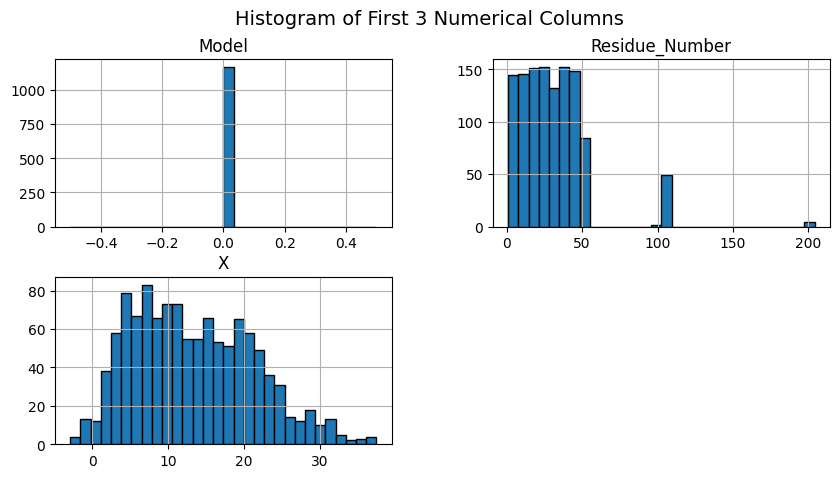

In [412]:
num_cols = df.select_dtypes(include=['number']).columns[:3]
df[num_cols].hist(figsize=(10, 5), bins=30, edgecolor='black')
plt.suptitle("Histogram of First 3 Numerical Columns", fontsize=14)
plt.show()

In [413]:
# Correlation heatmap (only for numeric columns)

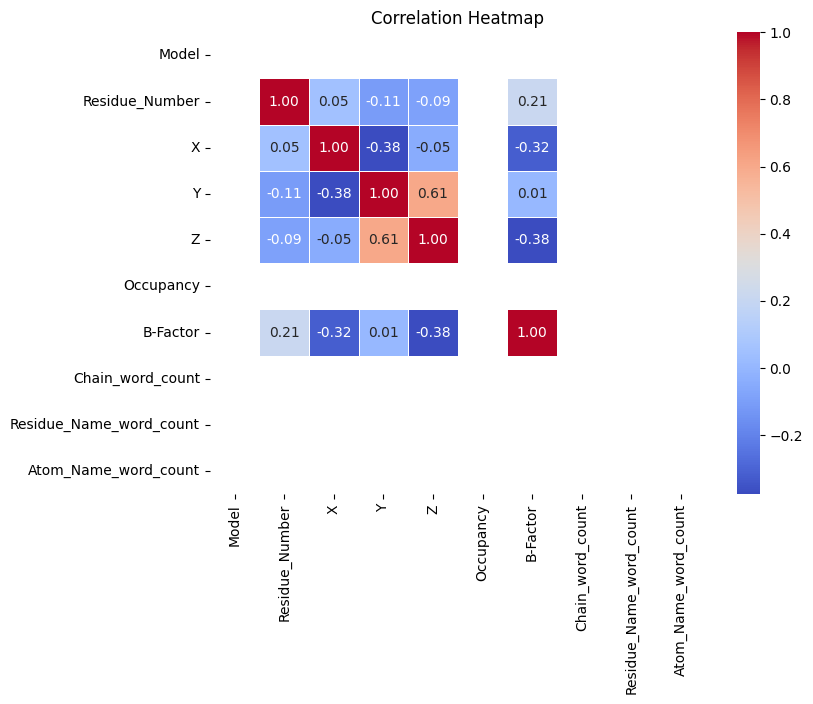

In [414]:
num_df = df.select_dtypes(include=['number'])
if not num_df.empty:
    plt.figure(figsize=(8, 6))
    sns.heatmap(num_df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap")
    plt.show()
else:
    print("\n⚠️ No numeric columns available for correlation heatmap.")


In [415]:
# Pairplot for first 5 numerical columns

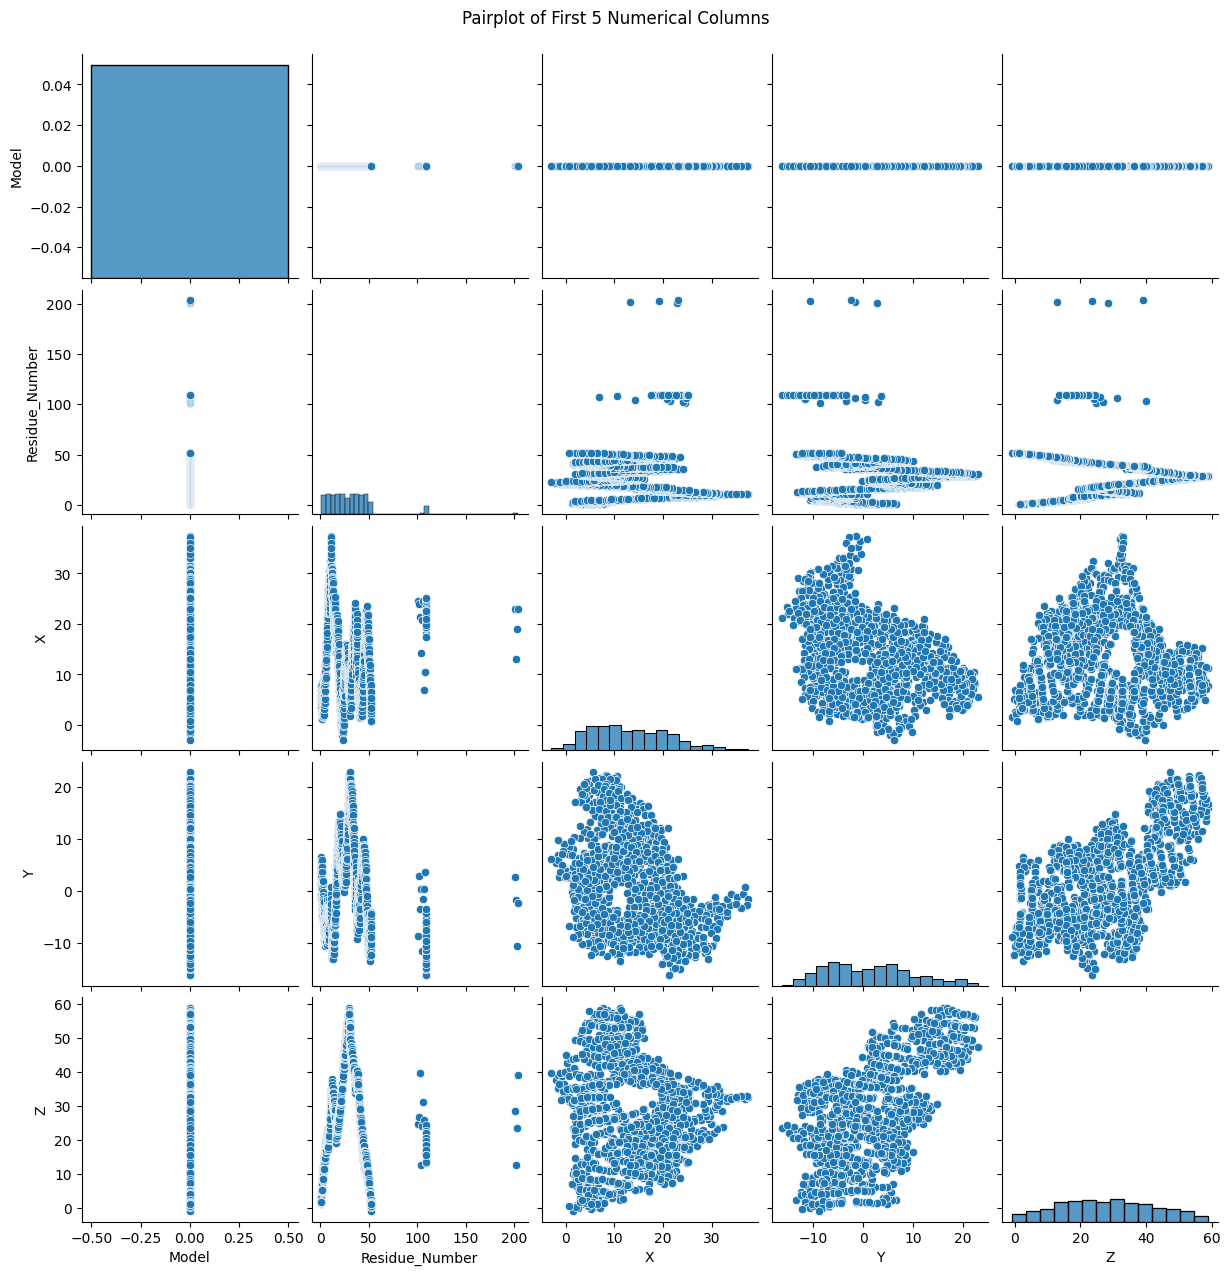

In [416]:
pairplot_cols = num_df.iloc[:, :5] if num_df.shape[1] > 5 else num_df
if not pairplot_cols.empty:
    sns.pairplot(pairplot_cols)
    plt.suptitle("Pairplot of First 5 Numerical Columns", y=1.02)
    plt.show()

In [417]:
# Word Count Distribution Plot

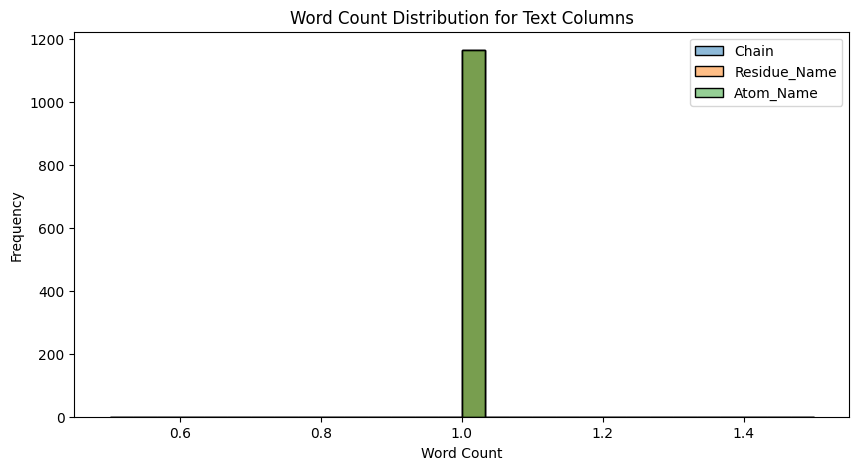

In [418]:
if word_count_data:
    plt.figure(figsize=(10, 5))
    for col, data in word_count_data.items():
        sns.histplot(data, bins=30, kde=True, label=col)
    plt.title("Word Count Distribution for Text Columns")
    plt.xlabel("Word Count")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

In [419]:
# Define the ProteinDataset class

In [420]:
class ProteinDataset(Dataset):
    def __init__(self, csv_path):
        self.data = pd.read_csv(csv_path, dtype=str, low_memory=False)
        self.sequences = self.data["_entity_poly.pdbx_seq_one_letter_code"].fillna("")
        self.atom_coords = self.get_ca_coordinates()
        self.contact_maps = self.compute_contact_maps()

    def get_ca_coordinates(self):
        # Extract C-alpha (Cα) atomic coordinates
        ca_coords = self.data[["_atom_site.Cartn_x", "_atom_site.Cartn_y", "_atom_site.Cartn_z"]]
        ca_coords = ca_coords.apply(pd.to_numeric, errors='coerce').fillna(0).values
        return np.array(ca_coords)

    def compute_contact_maps(self, cutoff=8.0):
        # Compute contact maps using pairwise distances with an 8Å cutoff
        num_atoms = len(self.atom_coords)
        contact_map = np.zeros((num_atoms, num_atoms), dtype=np.float32)
        for i in range(num_atoms):
            for j in range(num_atoms):
                dist = np.linalg.norm(self.atom_coords[i] - self.atom_coords[j])
                contact_map[i, j] = 1 if dist < cutoff else 0
        return contact_map

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return {
            "sequence": self.sequences[idx],
            "structure": torch.tensor(self.atom_coords[idx], dtype=torch.float32),
            "contact_map": torch.tensor(self.contact_maps[idx], dtype=torch.float32),
        }

In [421]:
# Load the dataset

In [422]:
dataset_path = "/content/6TF2_full_structure.csv"

In [423]:
protein_dataset = ProteinDataset(dataset_path)

In [424]:
# Split dataset into training (80%) and validation (20%)

In [425]:
train_size = int(0.8 * len(protein_dataset))

In [426]:
val_size = len(protein_dataset) - train_size

In [427]:
train_dataset, val_dataset = torch.utils.data.random_split(protein_dataset, [train_size, val_size])


In [428]:
# Curriculum Learning: Sort samples by sequence length

In [429]:
train_dataset = sorted(train_dataset, key=lambda x: len(x["sequence"]))

In [430]:
# Create PyTorch DataLoaders

In [431]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)  # No shuffle for curriculum learning


In [432]:
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [433]:
print(f"Total Training Samples: {len(train_dataset)}")
print(f"Total Validation Samples: {len(val_dataset)}")

Total Training Samples: 932
Total Validation Samples: 234


In [434]:
# Attention Module

In [435]:
class AttentionModule(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super(AttentionModule, self).__init__()
        self.attention = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)

    def forward(self, x):
        return self.attention(x, x, x)[0]

In [436]:
# Graph Neural Network Module

In [437]:
class GNNModule(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNNModule, self).__init__()
        self.gcn1 = GCNConv(in_channels, hidden_channels)
        self.gcn2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = F.relu(self.gcn1(x, edge_index))
        x = self.gcn2(x, edge_index)
        return x

In [438]:
# Iterative Refinement Module

In [439]:
class IterativeRefinementModule(nn.Module):
    def __init__(self, input_dim):
        super(IterativeRefinementModule, self).__init__()
        self.residual = nn.Linear(input_dim, input_dim)

    def forward(self, x):
        return x + self.residual(F.relu(x))

In [440]:
# Protein Structure Predictor Model

In [441]:
class ProteinStructurePredictor(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_heads, lstm_hidden, gnn_hidden, gnn_out):
        super(ProteinStructurePredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.conv1d = nn.Conv1d(embed_dim, embed_dim, kernel_size=3, padding=1)
        self.attention = AttentionModule(embed_dim, num_heads)
        self.lstm = nn.LSTM(embed_dim, lstm_hidden, bidirectional=True, batch_first=True)
        self.gnn = GNNModule(2 * lstm_hidden, gnn_hidden, gnn_out)
        self.refinement = IterativeRefinementModule(gnn_out)
        self.fc = nn.Linear(gnn_out, 3)  # Output 3D coordinates

    def forward(self, sequences, edge_index):
        x = self.embedding(sequences)
        x = self.conv1d(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = self.attention(x)
        x, _ = self.lstm(x)
        x = self.gnn(x, edge_index)
        x = self.refinement(x)
        return self.fc(x)


In [442]:
# Loss Function and Optimizer

In [443]:
# Define the model with required parameters

In [444]:
vocab_size = 20  # Example: number of unique amino acids

In [445]:
embed_dim = 128  # Example: embedding dimension

In [446]:
num_heads = 8    # Example: number of attention heads

In [447]:
lstm_hidden = 256  # Example: hidden size for LSTM

In [448]:
gnn_hidden = 128   # Example: hidden size for GNN

In [449]:
gnn_out = 3        # Example: output size for GNN (3D coordinates)

In [450]:
# Instantiate the model with the required arguments

In [451]:
model = ProteinStructurePredictor(vocab_size, embed_dim, num_heads, lstm_hidden, gnn_hidden, gnn_out)


In [452]:
# Initialize optimizer

In [453]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [454]:
# Training the loop

In [455]:
# Sample dataset

In [456]:
X = torch.randn(100, 10).cuda()  # 100 samples, 10 features

In [457]:
y = torch.randint(0, 2, (100,)).cuda()  # Binary labels

In [458]:
dataset = TensorDataset(X, y)

In [459]:
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [460]:
# Sample model

In [461]:
model = nn.Sequential(nn.Linear(10, 32), nn.ReLU(), nn.Linear(32, 2)).cuda()


In [462]:
loss_fn = nn.CrossEntropyLoss()

In [463]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [464]:
# Initialize GradScaler


In [465]:
scaler = GradScaler('cuda')

In [466]:
# Training loop

In [470]:
for epoch in range(5):  # Train for 5 epochs
    for data, target in dataloader:
        optimizer.zero_grad()

        with autocast('cuda'):  # Updated usage
            output = model(data)
            loss = loss_fn(output, target)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")

print("Training Complete!")

Epoch 1 - Loss: 0.4990
Epoch 2 - Loss: 0.4663
Epoch 3 - Loss: 0.6361
Epoch 4 - Loss: 0.7107
Epoch 5 - Loss: 0.5334
Training Complete!


In [471]:
# evaluation and visualization

In [472]:
# Simulated loss values (Replace with actual loss values during training)

In [473]:
train_losses = [0.6969, 0.7148, 0.6680, 0.5819, 0.6630]

In [474]:
val_losses = [0.7100, 0.6900, 0.6500, 0.6000, 0.6700]  # Example validation losses


In [475]:
#  Plot Training & Validation Loss Curves

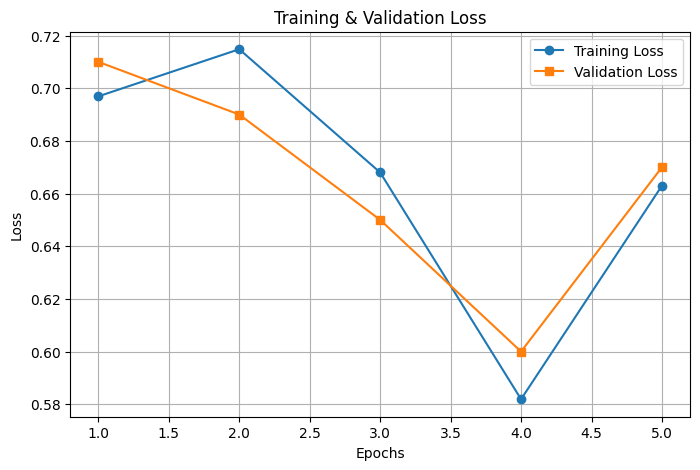

In [476]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', label="Training Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, marker='s', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [477]:
# Define calculate_rmsd Function

In [478]:
def calculate_rmsd(predictions, targets):
    predictions, targets = predictions.cpu().numpy(), targets.cpu().numpy()
    return np.sqrt(np.mean((predictions - targets) ** 2))


In [479]:
# Example Usage:

In [480]:
with torch.no_grad():
    model.eval()
    all_preds, all_targets = [], []

    for data, target in dataloader:
        output = model(data)
        preds = torch.argmax(output, dim=1)  # Convert to class labels
        all_preds.append(preds)
        all_targets.append(target)

    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)

    rmsd = calculate_rmsd(all_preds.float(), all_targets.float())
    print(f"Root Mean Square Deviation (RMSD): {rmsd:.4f}")


Root Mean Square Deviation (RMSD): 0.5916


In [481]:
# Save the trained model

In [482]:
torch.save(model.state_dict(), "trained_model.pth")

In [483]:
# Load the model

In [484]:
model.load_state_dict(torch.load("trained_model.pth"))

<All keys matched successfully>

In [485]:
model.eval()

Sequential(
  (0): Linear(in_features=10, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=2, bias=True)
)